In [86]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, roc_curve
import torch, gc
from transformers import BertweetTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding, EarlyStoppingCallback
# Load model directly 
# for using Twitter/twhin-bert-base 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoConfig
#####################
import numpy as np
from scipy.special import softmax
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
# Load the hydrogen dataset

df = pd.read_csv("hydrogen_small.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1000 non-null   object
 1   text    1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [88]:
df["label"].unique()

array(['Relevant', 'Irrelevant'], dtype=object)

In [89]:
df["text"].iloc[0]

'behind the wheel of a hydrogen powered car'

In [90]:
def clean_message(text):
    # Remove URLs from the message. Match anything starting wtih "http", "https", or "www"
    # followed by any non-whitespace characters (\S).
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove any tags from the message. Matches the '@' symbol followed by any letters,
    # numbers and underscores (\w).
    text = re.sub(r"@\w+", "", text)

    # Remove any non-ASCII characters from the text, such as emojis.
    # If you were dealing with a dataset containing non-English/Latin text, then you would
    # want to change this regular expression.
    # text = re.sub(r"[^\x00-\x7F]+", "", text)

    # Replace any sequences of consecutive whitespace with a single space character.
    # This includes newlines and spaces.
    text = re.sub(r"\s+", " ", text)

    # Finally, remove any leading or trailing whitespace with the strip() function.
    return text.strip()

In [91]:
df["text"] = df["text"].apply(clean_message)

In [92]:
df["text"].iloc[0]

'behind the wheel of a hydrogen powered car'

In [93]:
df["label"] = df["label"].map({
    "Irrelevant": 0, # Negative = 0
    "Relevant": 1  # Positive = 1
})

In [94]:
df["label"].unique()

array([1, 0])

In [95]:
df[df["label"] == 0].head(5)

,label,text
1,0,mls measurements of stratospheric hydrogen cya...
8,0,the cave nebula in hydrogen oxygen and sulfur ...
10,0,daytradingz smoke drifts up right now from the...
15,0,good day everyone how is that science coming a...
17,0,there s no rainbow trout on mars —yvon chouina...


In [96]:
df[df["label"] == 1].head(5)

,label,text
0,1,behind the wheel of a hydrogen powered car
2,1,ana gonzalez hernandez shares an overview of h...
3,1,toyota is giving away its first hydrogen car i...
4,1,agility develops storage systems for hydrogen ...
5,1,we are diversifying our energy basket with gas...


In [97]:
df["label"].value_counts()

label
1    547
0    453
Name: count, dtype: int64

SPLITTING TRAIN/TEST

In [98]:
X = df["text"].values
y = df["label"].values

In [99]:
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_state)
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 700
Testing set size: 300


TOKENIZING DATA

In [100]:
train_df = pd.DataFrame({"text": X_train, "label": y_train})
test_df = pd.DataFrame({"text": X_test, "label": y_test})
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [101]:
print("Train dataset:", train_ds)
print("Test dataset:", test_ds)

Train dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 700
})
Test dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 300
})


# Bertweet-base

In [102]:
model_name = "vinai/bertweet-base"
tokenizer = BertweetTokenizer.from_pretrained(model_name)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [103]:
# Function that is applied to all samples in the dataset.
def tokenize(batch):
    # We set truncation=True to truncate (cut off) messages that are too long.
    # NOTE: Not all models require this, you may get a warning indicating that it has no effect.
    # Padding is set to True if the model requires a fixed sequence length.
    return tokenizer(batch['text'], truncation=True, padding=True)

# Apply to both the training and testing datasets.
# We set batched to True which can enable parallel processing, however on my machine I found
# it did not scale to a greater number of threads.
train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [104]:
train_ds

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 700
})

DOWNLOADING THE ROBERTA MODEL

In [105]:
# Ensure the resources for any existing model has been freed.
try:
    del model
except NameError:
    pass

# Download/load the base model. We use the "vinai/bertweet-base" model here.
# Set the number of labels to the number of unique labels in the dataframe, which is 2.
# Set the problem type to single label classification, since we want one class for each sample.
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=df["label"].nunique(),
    problem_type="single_label_classification")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAINING THE MODEL


In [106]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    prec, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1)
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": recall,
        "f1": f1
    }

Hyperparameter Tuning

In [107]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

# Switch the model to training mode, enabling dropout etc layers.
model.train()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

trainer.train()

# Model evaluation
# Switch the model to evaluation mode, disabling dropout etc layers.
model.eval()
# Evaluate the datasets.
train_results = trainer.evaluate(train_ds)
test_results = trainer.evaluate(test_ds)
def display_evaluation(setname, results):
    print(f"{setname} Set Accuracy:", round(results["eval_accuracy"], 3))
    print(f"{setname} Set Precision:", round(results["eval_precision"], 3))
    print(f"{setname} Set Recall:", round(results["eval_recall"], 3))
    print(f"{setname} Set F1 score:", round(results["eval_f1"], 3))
display_evaluation("Training", train_results)
display_evaluation("Testing", test_results)



/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.479100,0.349763,0.910000,0.887006,0.957317,0.920821
2,0.235500,0.266681,0.910000,0.878453,0.969512,0.921739


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Training Set Accuracy: 0.937
Training Set Precision: 0.905
Training Set Recall: 0.99
Training Set F1 score: 0.945
Testing Set Accuracy: 0.91
Testing Set Precision: 0.878
Testing Set Recall: 0.97
Testing Set F1 score: 0.922


# Early Stopping

In [108]:
# _, X_small, _, y_small = train_test_split(X, y, stratify=y, random_state=random_state)
# X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(
#     X_small, y_small, stratify=y_small, test_size=0.3, random_state=random_state)
# small_train_df = pd.DataFrame({"text": X_small_train, "label": y_small_train})
# small_test_df = pd.DataFrame({"text": X_small_test, "label": y_small_test})
# small_train_ds = Dataset.from_pandas(small_train_df)
# small_test_ds = Dataset.from_pandas(small_test_df)
# small_train_ds = small_train_ds.map(tokenize, batched=True)
# small_test_ds = small_test_ds.map(tokenize, batched=True)
# print("Small training set size:", len(small_train_df))
# print("Small testing set size:", len(small_test_df))

# small_model = RobertaForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=df_subsampled["label"].nunique(),
#     problem_type="single_label_classification")
# small_model.train()

# small_training_args = TrainingArguments(
#     output_dir="./results",
#     num_train_epochs=50,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=64,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
#     # Added for early stopping.
# training_args2 = TrainingArguments(
#     output_dir="./results",
#     num_train_epochs=50,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=64,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
#     metric_for_best_model = "loss",
#     load_best_model_at_end = True
# )


# trainer2 = Trainer(
#     model=model,
#     args=training_args2,
#     train_dataset=train_ds,
#     eval_dataset=test_ds,
#     processing_class=tokenizer,
#     data_collator=DataCollatorWithPadding(tokenizer),
#     compute_metrics=compute_metrics,
#     callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
# )
# trainer2.train()

# Examining Attention Weights

In [109]:
# # Returns (matrix, tokens)
# def compute_attention_matrix(tokenizer, model, text):
#     # Feed into the model, you could also grab the token embedding directly
#     # from the dataset, in which case this step would be unnecessary. We want
#     # the output in Tensor format that we can feed to the model, so we use
#     # return_tensors="pt" (PyTorch Tensor). Lastly, send the tensor to
#     # whichever device the model is located on. This is unnecessary if you
#     # are running purely on the CPU, but needed for models on GPUs.
#     tokens = tokenizer(text, return_tensors="pt").to(model.device)
#     # We use torch.no_grad() to ensure the weights in the model are unchanged.
#     with torch.no_grad():
#         pred = model(**tokens, output_attentions=True)
#     # Stack layers. Depending on your model, this may have no effect.
#     # Move it back to the GPU if it was previously on the GPU.
#     attentions = torch.stack(pred.attentions).cpu()
#     # Remove the batch dimension, as there is only a zero value there.
#     attentions = attentions.squeeze(1)
#     # Average over the transformer layers and heads.
#     attentions = attentions.mean(dim=0).mean(dim=0)
#     # attentions now contains a matrix of importance from every token to every
#     # other token. e.g. if the message contained 10 tokens, it would be 10x10.
#     # Select the predicted class.
#     pred_class = pred.logits.cpu().argmax(-1).item()
#     # Also return a string representation of the tokens in the message.
#     # Plotting the integer token IDs would not be very meaningful.
#     token_strs = tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])
#     return (attentions, pred_class, token_strs)

In [110]:
# def plot_attention(attentions, tokens, title):
# # Enlarge figure to take up more of the width.
#     plt.figure(figsize=(10, 8))
#     plt.title(title)
#     # Plot heatmap.
#     sns.heatmap(
#     attentions, # Plot our attention matrix.
#     xticklabels=tokens, # Display token names on X axis.
#     yticklabels=tokens, # Display token names on Y axis.
#     cmap='binary', # Black for low, white for high
#     cbar=True # Display colour bar.
#     )
#     plt.show()

In [111]:
# def display_attention_matrix(tokenizer, model, text):
#     attention, pred_class, tokens = compute_attention_matrix(tokenizer, model, text)
#     pred_label = "Positive" if pred_class == 1 else "Negative"
#     plot_attention(attention, tokens, text + f"\nPredicted class: {pred_label}")


In [112]:
# display_attention_matrix(tokenizer, model, df[df["label"] == 0].iloc[0]["text"])

# ROC 

# clean the cache

In [113]:

# del model
# del tokenizer
# gc.collect()
# # clear the cache
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()
#     torch.cuda.ipc_collect()

# twitter/twhin-bert-base

In [114]:
# data tokenized
train_df2 = pd.DataFrame({"text": X_train, "label": y_train})
test_df2 = pd.DataFrame({"text": X_test, "label": y_test})
train_ds2 = Dataset.from_pandas(train_df2)
test_ds2 = Dataset.from_pandas(test_df2)
print("Train dataset:", train_ds2)
print("Test dataset:", test_ds2)

# model
model_name2 = "Twitter/twhin-bert-base"
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
# Preprocess text (username and link placeholders)
 


Train dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 700
})
Test dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 300
})


In [115]:
# Function that is applied to all samples in the dataset.
def tokenize2(batch):
    # We set truncation=True to truncate (cut off) messages that are too long.
    # NOTE: Not all models require this, you may get a warning indicating that it has no effect.
    # Padding is set to True if the model requires a fixed sequence length.
    return tokenizer2(batch['text'], truncation=True, padding=True, max_length=128)

# Apply to both the training and testing datasets.
# We set batched to True which can enable parallel processing, however on my machine I found
# it did not scale to a greater number of threads.
train_ds2 = train_ds2.map(tokenize2, batched=True)
test_ds2 = test_ds2.map(tokenize2, batched=True)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [116]:
train_ds2

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 700
})

In [117]:
try:
    del model2
except NameError:
    pass

# Download/load the base model. We use the "vinai/bertweet-base" model here.
# Set the number of labels to the number of unique labels in the dataframe, which is 2.
# Set the problem type to single label classification, since we want one class for each sample.
model2 = AutoModelForSequenceClassification.from_pretrained(
    model_name2,
    num_labels=df["label"].nunique(),
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [118]:
def compute_metrics2(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    prec, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1)
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": recall,
        "f1": f1
    }

In [119]:
training_args2 = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

# Switch the model to training mode, enabling dropout etc layers.
model2.train()

trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=train_ds2,
    eval_dataset=test_ds2,
    processing_class=tokenizer2,
    data_collator=DataCollatorWithPadding(tokenizer2),
    compute_metrics=compute_metrics2
)

trainer2.train()

# Model evaluation
# Switch the model to evaluation mode, disabling dropout etc layers.
model2.eval()
# Evaluate the datasets.
train_results2 = trainer2.evaluate(train_ds2)
test_results2 = trainer2.evaluate(test_ds2)
def display_evaluation(setname, results):
    print(f"{setname} Set Accuracy:", round(results["eval_accuracy"], 3))
    print(f"{setname} Set Precision:", round(results["eval_precision"], 3))
    print(f"{setname} Set Recall:", round(results["eval_recall"], 3))
    print(f"{setname} Set F1 score:", round(results["eval_f1"], 3))
display_evaluation("Training", train_results2)
display_evaluation("Testing", test_results2)

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.317200,0.321948,0.880000,0.836842,0.969512,0.898305
2,0.139100,0.365484,0.903333,0.857143,0.987805,0.917847
3,0.158400,0.289093,0.916667,0.892655,0.963415,0.926686
4,0.108700,0.312101,0.916667,0.892655,0.963415,0.926686


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Training Set Accuracy: 0.974
Training Set Precision: 0.964
Training Set Recall: 0.99
Training Set F1 score: 0.977
Testing Set Accuracy: 0.917
Testing Set Precision: 0.893
Testing Set Recall: 0.963
Testing Set F1 score: 0.927


# Early stopping

In [120]:
# _, X_small, _, y_small = train_test_split(X, y, stratify=y, random_state=random_state)
# X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(
#     X_small, y_small, stratify=y_small, test_size=0.3, random_state=random_state)
# small_train_df = pd.DataFrame({"text": X_small_train, "label": y_small_train})
# small_test_df = pd.DataFrame({"text": X_small_test, "label": y_small_test})
# small_train_ds = Dataset.from_pandas(small_train_df)
# small_test_ds = Dataset.from_pandas(small_test_df)
# small_train_ds = small_train_ds.map(tokenize2, batched=True)
# small_test_ds = small_test_ds.map(tokenize2, batched=True)
# print("Small training set size:", len(small_train_df))
# print("Small testing set size:", len(small_test_df))

# # small_model = RobertaForSequenceClassification.from_pretrained(
# #     model_name,
# #     num_labels=df_subsampled["label"].nunique(),
# #     problem_type="single_label_classification")
# # small_model.train()

# # small_training_args = TrainingArguments(
# #     output_dir="./results",
# #     num_train_epochs=50,
# #     per_device_train_batch_size=16,
# #     per_device_eval_batch_size=64,
# #     eval_strategy="epoch",
# #     save_strategy="epoch",
# #     learning_rate=2e-5,
# #     weight_decay=0.01,
# #     logging_dir="./logs",
# #     logging_steps=10,
# #     # Added for early stopping.
# training_args2 = TrainingArguments(
#     output_dir="./results",
#     num_train_epochs=50,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=64,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
#     metric_for_best_model = "loss",
#     load_best_model_at_end = True
# )


# trainer2 = Trainer(
#     model=model2,
#     args=training_args2,
#     train_dataset=train_ds,
#     eval_dataset=test_ds,
#     processing_class=tokenizer2,
#     data_collator=DataCollatorWithPadding(tokenizer2),
#     compute_metrics=compute_metrics2,
#     callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
# )
# trainer2.train()

# Examine Attention Weights

In [121]:
# Returns (matrix, tokens)
def compute_attention_matrix(tokenizer, model, text):
    # Feed into the model, you could also grab the token embedding directly
    # from the dataset, in which case this step would be unnecessary. We want
    # the output in Tensor format that we can feed to the model, so we use
    # return_tensors="pt" (PyTorch Tensor). Lastly, send the tensor to
    # whichever device the model is located on. This is unnecessary if you
    # are running purely on the CPU, but needed for models on GPUs.
    tokens = tokenizer(text, return_tensors="pt").to(model.device)
    # We use torch.no_grad() to ensure the weights in the model are unchanged.
    with torch.no_grad():
        pred = model(**tokens, output_attentions=True)
    # Stack layers. Depending on your model, this may have no effect.
    # Move it back to the GPU if it was previously on the GPU.
    attentions = torch.stack(pred.attentions).cpu()
    # Remove the batch dimension, as there is only a zero value there.
    attentions = attentions.squeeze(1)
    # Average over the transformer layers and heads.
    attentions = attentions.mean(dim=0).mean(dim=0)
    # attentions now contains a matrix of importance from every token to every
    # other token. e.g. if the message contained 10 tokens, it would be 10x10.
    # Select the predicted class.
    pred_class = pred.logits.cpu().argmax(-1).item()
    # Also return a string representation of the tokens in the message.
    # Plotting the integer token IDs would not be very meaningful.
    token_strs = tokenizer2.convert_ids_to_tokens(tokens["input_ids"][0])
    return (attentions, pred_class, token_strs)

In [122]:
def plot_attention(attentions, tokens, title):
# Enlarge figure to take up more of the width.
    plt.figure(figsize=(10, 8))
    plt.title(title)
    # Plot heatmap.
    sns.heatmap(
    attentions, # Plot our attention matrix.
    xticklabels=tokens, # Display token names on X axis.
    yticklabels=tokens, # Display token names on Y axis.
    cmap='binary', # Black for low, white for high
    cbar=True # Display colour bar.
    )
    plt.show()

In [123]:
def display_attention_matrix(tokenizer, model, text):
    attention, pred_class, tokens = compute_attention_matrix(tokenizer, model, text)
    pred_label = "Positive" if pred_class == 1 else "Negative"
    plot_attention(attention, tokens, text + f"\nPredicted class: {pred_label}")

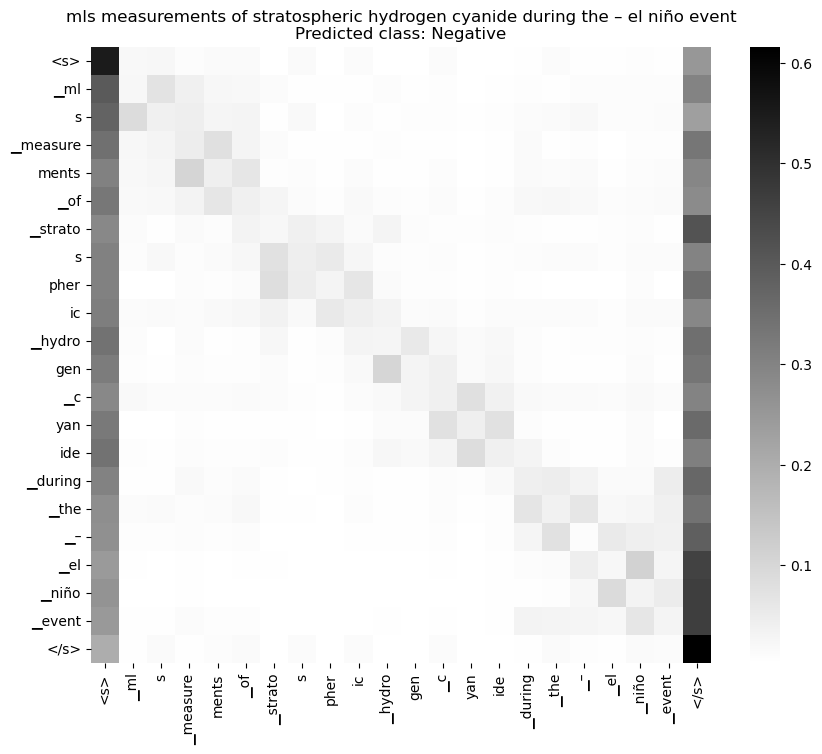

In [124]:
display_attention_matrix(tokenizer2, model2, df[df["label"] == 0].iloc[0]["text"])

# ROC

In [125]:
pred = trainer.predict(test_ds)
pred2 = trainer2.predict(test_ds2)

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [126]:
# Convert to PyTorch tensor, apply softmax, and convert back to a numpy array.
pred_probs = torch.nn.functional.softmax(torch.Tensor(pred.predictions)).numpy()
pred_probs2 = torch.nn.functional.softmax(torch.Tensor(pred2.predictions)).numpy()

/var/folders/h8/0ky72nmj19j1n2cc_zs0_7pm0000gn/T/ipykernel_4133/4158278439.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probs = torch.nn.functional.softmax(torch.Tensor(pred.predictions)).numpy()
/var/folders/h8/0ky72nmj19j1n2cc_zs0_7pm0000gn/T/ipykernel_4133/4158278439.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probs2 = torch.nn.functional.softmax(torch.Tensor(pred2.predictions)).numpy()


In [127]:
roc_index_nn = roc_auc_score(y_test, pred_probs[:, 1])
roc_index_nn2 = roc_auc_score(y_test, pred_probs2[:, 1])

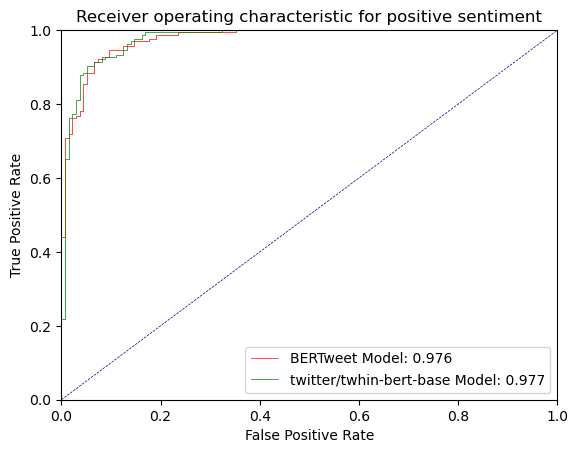

In [128]:
# Compute the ROC curve.
bertweet_nn, tpr_bertweet, bertweet_thresholds_nn = roc_curve(y_test, pred_probs[:,1])
twitter_nn, tpr_twitter, twitter_thresholds_nn = roc_curve(y_test, pred_probs2[:,1])
# And plot it on a line graph, similarly to what we did in previous weeks.
plt.plot(bertweet_nn, tpr_bertweet, label="BERTweet Model: {:.3f}".format(roc_index_nn),
color='red', lw=0.5)
plt.plot(twitter_nn, tpr_twitter, label="twitter/twhin-bert-base Model: {:.3f}".format(roc_index_nn2),
color='green', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic for positive sentiment")
plt.legend(loc="lower right")
plt.show()

# Regression Model

In [129]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Use the processed df with numeric labels instead of the original df_hydrogen
df_tfidf = pd.read_csv('tfidf_features_small.csv')

# Use the already processed df that has numeric labels (0, 1)
df_tfidf['label'] = df['label'].values  # Use df (processed) instead of df_hydrogen (original)

X_tfidf = df_tfidf.drop(columns=['label'])
Y_tfidf = df_tfidf['label']

random_state = 10
test_set_size = 0.3 # 30%
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, Y_tfidf, test_size=test_set_size, stratify=Y_tfidf, random_state=random_state)

print("Size of training set:", len(X_train_tfidf))
print("Size of testing set:", len(X_test_tfidf))
print("Unique values in y_test_tfidf:", np.unique(y_test_tfidf))

Size of training set: 700
Size of testing set: 300
Unique values in y_test_tfidf: [0 1]


In [130]:
# from sklearn.preprocessing import StandardScaler
# # initialise a standard scaler object
# scaler = StandardScaler()
# # visualise min, max, mean and standard dev of data before scaling
# print("Before scaling\n-------------")
# for i in range(5):
#     col = X_train[:,i]
#     print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".format(i,
# min(col), max(col), np.mean(col), np.std(col)))
# # learn the mean and std.dev of variables from training data
# # then use the learned values to transform training data
# X_train = scaler.fit_transform(X_train, y_train)
# print("After scaling\n-------------")
# for i in range(5):
#     col = X_train[:,i]
#     print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".format(i,
# min(col), max(col), np.mean(col), np.std(col)))
# # use the statistic that you learned from training to transform test data
# # NEVER learn from test data, this is supposed to be a set of dataset
# # that the model has never seen before
# X_test = scaler.transform(X_test)

In [131]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(random_state=random_state)
# fit it to training data
model_lr.fit(X_train_tfidf, y_train_tfidf)

LogisticRegression(random_state=10)

In [132]:
from sklearn.metrics import classification_report
print("training accuracy:", model_lr.score(X_train_tfidf, y_train_tfidf))
print("testing accuracy:", model_lr.score(X_test_tfidf, y_test_tfidf))

y_pred = model_lr.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_pred))

training accuracy: 0.99
testing accuracy: 0.9033333333333333
              precision    recall  f1-score   support

           0       0.97      0.82      0.88       136
           1       0.86      0.98      0.92       164

    accuracy                           0.90       300
   macro avg       0.92      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300



In [133]:
y_pred_proba_lr = model_lr.predict_proba(X_test_tfidf)
roc_index_lr = roc_auc_score(y_test_tfidf, y_pred_proba_lr[:, 1])

# Now compute ROC curve for logistic regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_tfidf, y_pred_proba_lr[:, 1])

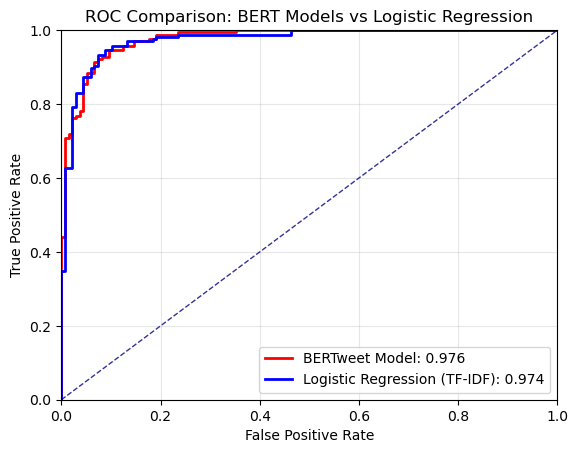

In [134]:
# Compute the ROC curve for all models using the correct y_test
# Make sure all models use the same test set from the BERT models
plt.plot(bertweet_nn, tpr_bertweet, label="BERTweet Model: {:.3f}".format(roc_index_nn),
         color='red', lw=2)
# plt.plot(twitter_nn, tpr_twitter, label="twitter/twhin-bert-base Model: {:.3f}".format(roc_index_nn2),
#          color='green', lw=2)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression (TF-IDF): {:.3f}".format(roc_index_lr),
         color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison: BERT Models vs Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [135]:
from sklearn.metrics import roc_auc_score
y_pred_proba_lr = model_lr.predict_proba(X_test_tfidf)
bertweet_nn, tpr_bertweet, bertweet_thresholds_nn = roc_curve(y_test_tfidf, pred_probs[:,1])
roc_index_lr = roc_auc_score(y_test_tfidf, y_pred_proba_lr[:, 1])
print("ROC index on test for `model_lr`:", roc_index_lr)
print("ROC index on test for `BERTweet`:", roc_index_nn)


ROC index on test for `model_lr`: 0.9739508608321378
ROC index on test for `BERTweet`: 0.9764616212338593
